<a href="https://colab.research.google.com/github/roshananduri/FingerprintRecogniser/blob/main/Fingerprint_Recogniser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import imageio as io
from glob import glob
from PIL import Image
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

warnings.filterwarnings('ignore')



In [4]:
#reading Data

data=glob("/content/drive/MyDrive/Deep Learning Projects 33 - Fingerprint Recognizer Model using DL/dataset_FVC2000_DB4_B/dataset/train_data/*")

In [5]:
len(data)

800

In [6]:
!nvidia-smi

Wed Dec 14 13:15:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
#load images and store it in list after conversion
import skimage.transform as sk
images=[]
def read_img(data):
  for i in range(len(data)):
    img=io.imread(data[i])
    img=sk.resize(img,(224,224))
    images.append(img)
  return images
read_img(data)

[array([[0.        , 0.        , 0.        , ..., 0.99607843, 0.99607843,
         0.99607843],
        [0.        , 0.        , 0.        , ..., 0.99607843, 0.99607843,
         0.99607843],
        [0.        , 0.        , 0.        , ..., 0.99607843, 0.99607843,
         0.99607843],
        ...,
        [0.        , 0.        , 0.        , ..., 0.0080032 , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.10532213, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.19943978, 0.        ,
         0.        ]]),
 array([[0.99607843, 0.99607843, 0.99607843, ..., 0.99607843, 0.99607843,
         0.99607843],
        [0.99607843, 0.99607843, 0.99607843, ..., 0.99607843, 0.99607843,
         0.99607843],
        [0.99607843, 0.99607843, 0.99607843, ..., 0.99607843, 0.99607843,
         0.99607843],
        ...,
        [0.35334134, 0.32765106, 0.23009204, ..., 0.14245698, 0.3497399 ,
         0.50004002],
        [0.5

In [8]:
#converting to numpy array
img_arr =np.asarray(images)
img_arr=img_arr.astype('float32')

img_arr.shape

(800, 224, 224)

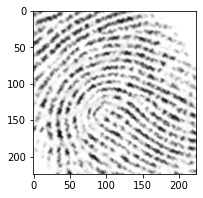

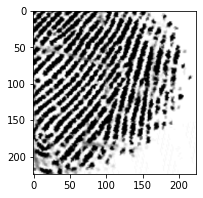

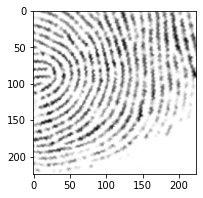

In [17]:
#plotting few images
for i in range(456,459):
  plt.figure(figsize=[3,3])
  img=np.reshape(img_arr[i],(224,224))
  plt.imshow(img,cmap='gray')
  plt.show()

In [19]:
#preprocessing
#reshaping to 224,224,1 shape
img_arr=img_arr.reshape(-1,224,224,1)

#shape of images
print('Converted shape:',img_arr.shape)

Converted shape: (800, 224, 224, 1)


In [20]:
#rescaling
img_max=np.max(img_arr)
img_arr=img_arr/img_max
print(img_arr[1])

[[[0.99607843]
  [0.99607843]
  [0.99607843]
  ...
  [0.99607843]
  [0.99607843]
  [0.99607843]]

 [[0.99607843]
  [0.99607843]
  [0.99607843]
  ...
  [0.99607843]
  [0.99607843]
  [0.99607843]]

 [[0.99607843]
  [0.99607843]
  [0.99607843]
  ...
  [0.99607843]
  [0.99607843]
  [0.99607843]]

 ...

 [[0.35334134]
  [0.32765105]
  [0.23009203]
  ...
  [0.14245698]
  [0.3497399 ]
  [0.50004   ]]

 [[0.54557824]
  [0.45794317]
  [0.2645058 ]
  ...
  [0.1917567 ]
  [0.4128051 ]
  [0.57462984]]

 [[0.61664665]
  [0.5002001 ]
  [0.27410963]
  ...
  [0.2042417 ]
  [0.44017607]
  [0.62937176]]]


In [22]:
#splitting datset
X_train,X_test,y_train,y_test=train_test_split(img_arr,img_arr,test_size=0.3,random_state=42)


In [24]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((560, 224, 224, 1),
 (240, 224, 224, 1),
 (560, 224, 224, 1),
 (240, 224, 224, 1))

In [25]:
#initializing parameters
batch_size=128
epochs=300
channel=1
x,y=224,224
input_img=Input(shape=(x,y,channel))

In [30]:
def auto_enc(input_img):
    ''' encoder'''
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    encoder_last = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    ''' decoder '''
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_last) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    dec = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return dec

In [31]:
#model
model=Model(input_img,auto_enc(input_img))


In [32]:
#compile
model.compile(loss='mean_squared_error',optimizer=tensorflow.keras.optimizers.RMSprop())

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)       7385

In [33]:
''' training '''
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1, validation_data =(X_test, y_test))

Epoch 1/300
5/5 [==============================] - 25s 2s/step - loss: 0.1560 - val_loss: 0.1269
Epoch 2/300
5/5 [==============================] - 3s 637ms/step - loss: 0.1332 - val_loss: 0.1301
Epoch 3/300
5/5 [==============================] - 3s 645ms/step - loss: 0.1144 - val_loss: 0.1074
Epoch 4/300
5/5 [==============================] - 3s 650ms/step - loss: 0.0858 - val_loss: 0.0984
Epoch 5/300
5/5 [==============================] - 3s 648ms/step - loss: 0.1008 - val_loss: 0.0515
Epoch 6/300
5/5 [==============================] - 3s 649ms/step - loss: 0.1008 - val_loss: 0.0534
Epoch 7/300
5/5 [==============================] - 3s 653ms/step - loss: 0.0395 - val_loss: 0.1029
Epoch 8/300
5/5 [==============================] - 3s 654ms/step - loss: 0.0537 - val_loss: 0.0250
Epoch 9/300
5/5 [==============================] - 3s 662ms/step - loss: 0.0326 - val_loss: 0.0573
Epoch 10/300
5/5 [==============================] - 3s 662ms/step - loss: 0.0320 - val_loss: 0.0224
Epoch 11/30

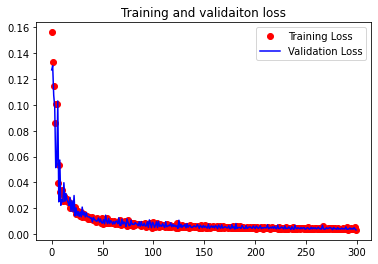

In [38]:
#validationa and training loss graph
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(300)
plt.figure()
plt.plot(epochs,loss,'ro',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Training and validaiton loss')
plt.legend()
plt.show()

In [39]:
y_pred=model.predict(X_test)

8/8 [==============================] - 2s 130ms/step


Test Images


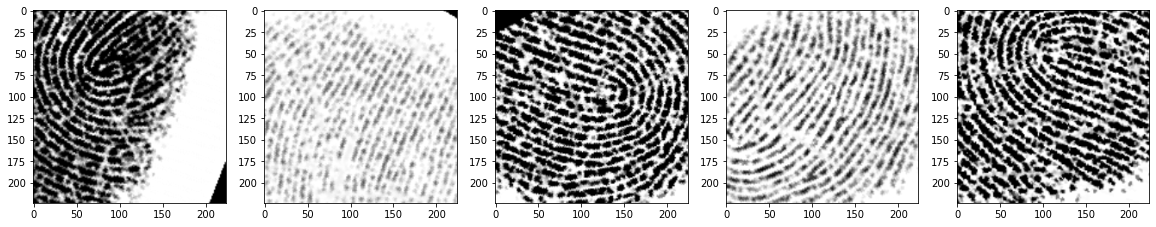

Reconstruction of Test Images


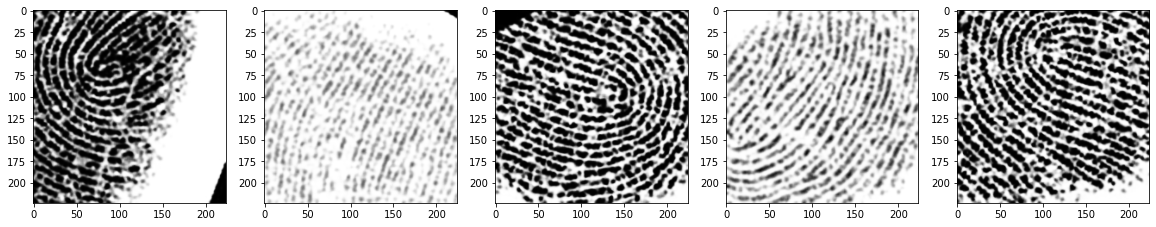

In [41]:
#visualization
plt.figure(figsize=(20,4))
print('Test Images')
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(y_test[i,...,0],cmap='gray')
plt.show()

plt.figure(figsize=(20,4))
print('Reconstruction of Test Images')
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(y_pred[i,...,0],cmap='gray')

plt.show()

In [42]:
new_data=glob('/content/drive/MyDrive/Deep Learning Projects 33 - Fingerprint Recognizer Model using DL/dataset_FVC2000_DB4_B/dataset/real_data/*')

In [43]:
test_img=[]
def read_images(data):
  for i in range(len(data)):
    img=io.imread(data[i])
    img=sk.resize(img,(224,224))
    test_img.append(img)
  return test_img

In [44]:
new_data=read_images(new_data)

In [45]:
len(new_data)

10

In [47]:
#preprocessing
new_data=np.asarray(new_data)
new_data=new_data.astype('float32')
new_data[1]

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.80160064, 0.829932  , 0.8979592 , ..., 0.98615444, 0.995118  ,
        0.9941577 ],
       [0.83833534, 0.8558623 , 0.9070028 , ..., 0.9939176 , 0.9847939 ,
        0.97182876],
       [0.8755502 , 0.8837135 , 0.9187675 , ..., 0.99847937, 0.97350943,
        0.947579  ]], dtype=float32)

In [48]:
new_data.shape

(10, 224, 224)

In [51]:
#reshaping
new_data=new_data.reshape(-1,224,224,1)

In [52]:
#scaling
new_data=new_data/np.max(new_data)
new_data[1]

array([[[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       ...,

       [[0.80160064],
        [0.829932  ],
        [0.8979592 ],
        ...,
        [0.98615444],
        [0.995118  ],
        [0.9941577 ]],

       [[0.83833534],
        [0.8558623 ],
        [0.9070028 ],
        ...,
        [0.9939176 ],
        [0.9847939 ],
        [0.97182876]],

       [[0.8755502 ],
        [0.8837135 ],
        [0.9187675 ],
        ...,
        [0.99847937],
        [0.97350943],
        [0.947579  ]]], dtype=float32)

In [53]:
#prediction
y_pred_new=model.predict(new_data)


1/1 [==============================] - 0s 470ms/step


Test Real World Images


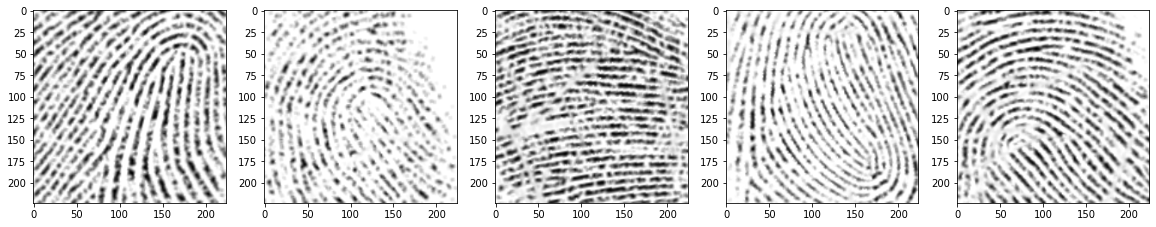

Reconstruction of Real World Images


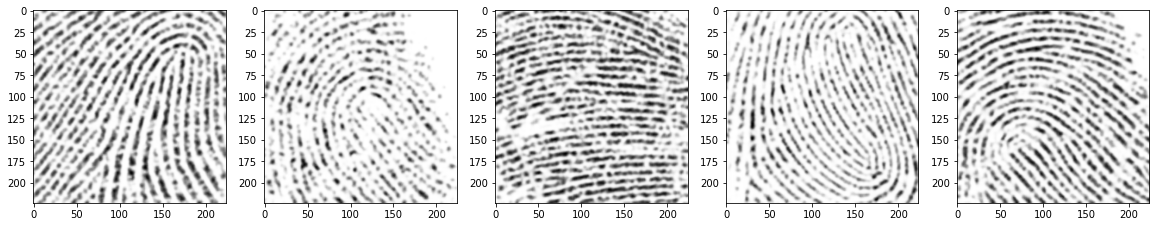

In [54]:
''' visualization '''
plt.figure(figsize=(20, 4))
print("Test Real World Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(new_data[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Real World Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(y_pred_new[i, ..., 0], cmap='gray')  
plt.show()